# Mécanisme d'attention
Dans ce notebook, nous allons explorer un problème de type *sequence-to-sequence*. Pour cela nous allons créer un jeu de donnée *jouet* (toy dataset) et l'analyser avec un réseau convolutif 1D. Nous comparerons les performances avant et après l'introduction d'une couche d'**attention**, ce qui nous permettra de comprendre la pertinence de ce mécanisme.

### imports python

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from io import open
import glob
import os
import matplotlib.pyplot as plt

## 1. Génération des données
On génère des sequences 1D contenant chacunes deux formes triangulaires et deux formes rectangulaires (step). La position et la hauteur de chacune des formes est choisie aléatoirement, la seule contrainte étant que les formes ne doivent pas se chevaucher.  
**L'objectif du notebook sera d'entrainer un modèle permettant de transformer un séquence de telle manière que les deux triangles et les deux rectangles fassent la même hauteur, respectivement.**  
[Source originale de l'exercice](https://fleuret.org/dlc/materials/dlc-handout-13-2-attention-mechanisms.pdf)

In [41]:
# hyperparamètres pour la génération
n_sequence = 5000 # nombres de séquences générées
n_points = 100 # nombre de points par séquence
width = 8 # largeur des triangles et step ajoutés dans les séquences

In [42]:
def make_shape(x, y, center, height, width=8, triangle=False):
    mask_up = (x <= center+width/2)
    mask_down = (x >= center-width/2)
    if triangle:
        y[mask_down & (x<=center)] = height * (x[mask_down & (x<=center)]-center+width/2) / 4
        y[mask_up & (x>center)] = height - height * (x[mask_up & (x>center)]-center) / 4
    else:
        y[mask_down & mask_up] = height
    return y

In [43]:
def difference_matrix(a):
    x = np.reshape(a, (len(a), 1))
    return x - x.transpose()

In [44]:
np.random.seed(42)

x_data = np.linspace(0, 100, 100)

s = 0
sequences_input = []
sequences_target_shape = [] # pour les parties 2 & 3
sequences_target_position = [] # pour la partie 4

while s < n_sequence:
    centers = np.sort(np.random.rand(4)*100) # génération aléatoire de la position des formes
    if centers.min()-width/2 < 0 or centers.max()+width/2 > 100:
        continue
    
    diff_matrix = np.abs(difference_matrix(centers))
    diag_mask = np.eye(diff_matrix.shape[0], diff_matrix.shape[1], dtype=bool)
    if diff_matrix[~diag_mask].min() >= width: # chevauchement ?
        s += 1
        heights = np.random.randint(2,29, 4) # génération aléatoire de la taille des formes
        triangle_idxs = np.random.choice(4, 2, replace=False) # choix aléatoire de la position des triangles
        mask_idx = np.zeros_like(heights).astype(bool)
        mask_idx[triangle_idxs] = True

        h_target_triangle = heights[mask_idx].mean() # cible = hauteur moyenne des triangles
        h_target_step = heights[~mask_idx].mean() # cible = hauteur moyenne des rectangle
        
        h_target_left = heights[:2].mean() # cible = hauteur moyenne des 2 formes les plus à gauche
        h_target_right = heights[2:].mean() # cible = hauteur moyenne des 2 formes les plus à droite

        seq = np.zeros_like(x_data)
        seq_target_shape = np.zeros_like(x_data)
        seq_target_position = np.zeros_like(x_data)
        for i, (c, h) in enumerate(zip(centers, heights)):
            if i in triangle_idxs:
                seq = make_shape(x_data, seq, c, h, triangle=True, width=width)
                seq_target_shape = make_shape(x_data, seq_target_shape, c, h_target_triangle, triangle=True, width=width)
                if i <2 :
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_left,
                                                     triangle=True, width=width)
                else:
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_right,
                                                     triangle=True, width=width)
            else:
                seq = make_shape(x_data, seq, c, h)
                seq_target_shape = make_shape(x_data, seq_target_shape, c, h_target_step)
                if i <2 :
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_left, width=width)
                else:
                    seq_target_position = make_shape(x_data, seq_target_position, c, h_target_right, width=width)
                
        sequences_input.append(seq)
        sequences_target_shape.append(seq_target_shape)
        sequences_target_position.append(seq_target_position)
        
sequences_input = np.array(sequences_input).reshape(n_sequence, 1, 100)
sequences_target_shape = np.array(sequences_target_shape).reshape(n_sequence, 1, 100)
sequences_target_position = np.array(sequences_target_position).reshape(n_sequence, 1, 100)

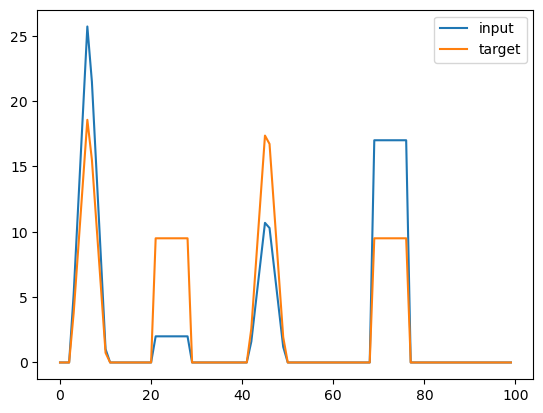

In [45]:
plt.plot(sequences_input[134,0], label='input')
plt.plot(sequences_target_shape[134,0], label='target')
plt.legend()

### Création des datasets pytorch

In [46]:
train_input, test_input, train_target, test_target = train_test_split(sequences_input,
                                                                      sequences_target_shape,
                                                                      test_size=0.25)

# Normalisation des données
mu, std = train_input.mean(), train_input.std()
train_input = (train_input-mu)/std
test_input = (test_input-mu)/std

# Conversion des tableaux numpy vers des tenseurs reconnus par pytorch :
train_input = torch.from_numpy(train_input).type(torch.FloatTensor)
train_target = torch.from_numpy(train_target).type(torch.FloatTensor)
train_data = TensorDataset(train_input, train_target)
print('dataset entrainement : ', train_data)

test_input = torch.from_numpy(test_input).type(torch.FloatTensor)
test_target = torch.from_numpy(test_target).type(torch.FloatTensor)
test_data = TensorDataset(test_input, test_target)
print('dataset entrainement : ', test_data)

dataset entrainement :  <torch.utils.data.dataset.TensorDataset object at 0x7f0f240e2d10>
dataset entrainement :  <torch.utils.data.dataset.TensorDataset object at 0x7f0f1f3b8910>


## 2. Modèle sans mécanisme d'attention
**À faire** : Créer un modèle pytorch prenant en entrée une séquence et retournant en sortie une autre séquence, obtenue par l'application de 4 couches de convolution 1D, chacune composée de 64 convolutions de taille 5.  
On choisira un padding permettant de conserver la longeur originale des séquences et on appliquera une fonction d'activation ReLU après chaque convolution.

In [47]:
class Net_conv1d(nn.Module):
    def __init__(self):
        super(Net_conv1d, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=5, padding=2)            
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
model_conv1d = Net_conv1d()

### Entrainement

In [50]:
# Hyperparamètres
N_epochs = 50
learning_rate = 0.001
batch_size=50

n_iteration_per_epoch = len(train_input) // batch_size +1
n_test_loops = np.arange(0, N_epochs*n_iteration_per_epoch, n_iteration_per_epoch)

# Outil de chargement des données
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

**À faire** : choisir une fonction de coût pertinente pour le problème considéré.

In [51]:
loss_function = nn.MSELoss()

In [52]:
def train_loop(model, optimizer, loss_function, train_loader, test_loader, N_epochs):
    losses = []   
    val_losses = []
    for epoch in range(N_epochs):  # Boucle sur les époques    
        for inputs, targets in train_loader:
            #Propagation en avant
            preds = model(inputs) # Equivalent à model.forward(features)

            #Calcul du coût
            loss = loss_function(preds, targets)

            #on sauvegarde la loss pour affichage futur
            losses.append(loss.item())

            #Effacer les gradients précédents
            optimizer.zero_grad()

            #Calcul des gradients (rétro-propagation)
            loss.backward()

            #Mise à jour des poids : un pas de l'optimiseur
            optimizer.step()
        print('Epoque',epoch, 'loss', loss.item())
        
        val_losses.append(test_loop(model, test_loader))

    print('Entrainement terminé')
    
    return losses, val_losses

def test_loop(model, test_loader):
    with torch.no_grad():
        val_loss = []
        for inputs, targets in test_loader:
            #Propagation en avant
            preds = model(inputs)

            #Calcul du coût
            loss = loss_function(preds, targets)

            #on sauvegarde la loss pour affichage futur
            val_loss.append(loss.item())
        
    return np.array(val_loss).mean()

def draw_loss(losses, val_losses, n_test_loops):
    # Afficher l'évolution de la fonction de coût
    fig, axes = plt.subplots(figsize=(8,6))
    axes.plot(losses,'r-',lw=2,label='Fonction de cout')
    axes.plot(n_test_loops, val_losses,'b-',lw=2,label='Fonction de cout - validation')
    axes.set_xlabel('N iterations',fontsize=18)
    axes.set_ylabel('Cout',fontsize=18)
    plt.yscale('log')
    plt.legend(loc='upper right',fontsize=16)

In [53]:
optimizer = optim.Adam(model_conv1d.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_conv1d, optimizer, loss_function, train_dataloader, test_dataloader, N_epochs)

Epoque 0 loss 4.933625221252441
Epoque 1 loss 3.475761651992798
Epoque 2 loss 3.2094433307647705
Epoque 3 loss 3.511645793914795
Epoque 4 loss 3.6290266513824463
Epoque 5 loss 3.5394718647003174
Epoque 6 loss 2.9265363216400146
Epoque 7 loss 3.4592785835266113
Epoque 8 loss 3.216373920440674
Epoque 9 loss 3.640739917755127
Epoque 10 loss 3.1601643562316895
Epoque 11 loss 3.0930144786834717
Epoque 12 loss 3.2623956203460693
Epoque 13 loss 3.5347983837127686
Epoque 14 loss 2.919551134109497
Epoque 15 loss 3.125582456588745
Epoque 16 loss 3.537785053253174
Epoque 17 loss 3.901379346847534
Epoque 18 loss 3.1278128623962402
Epoque 19 loss 2.9949495792388916
Epoque 20 loss 3.276859760284424
Epoque 21 loss 2.838369607925415
Epoque 22 loss 3.402618646621704
Epoque 23 loss 3.4156601428985596
Epoque 24 loss 3.0543670654296875
Epoque 25 loss 2.4304561614990234
Epoque 26 loss 2.9260993003845215
Epoque 27 loss 3.480707883834839
Epoque 28 loss 3.5550289154052734
Epoque 29 loss 3.4107577800750732
Epo

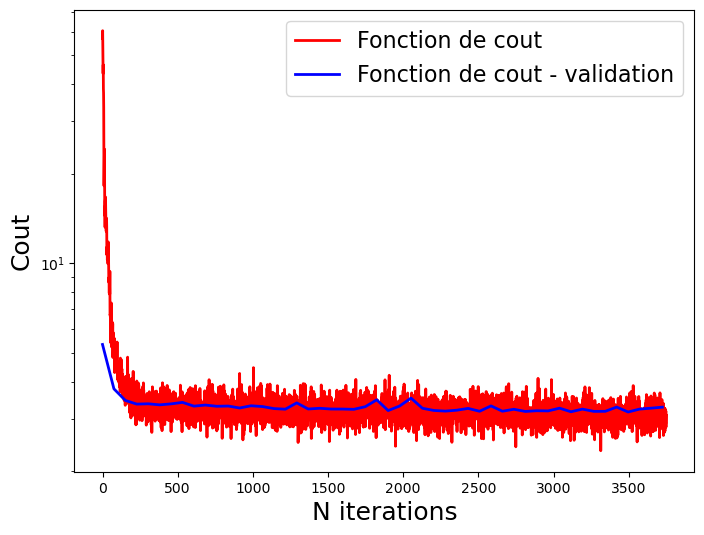

In [54]:
draw_loss(losses, val_losses, n_test_loops)

### Test

In [86]:
test_output_conv1d = model_conv1d(test_input)

In [87]:
print(f'Loss sur le dataset de test = {loss_function(test_output_conv1d, test_target):.3f}')

Loss sur le dataset de test = 3.288


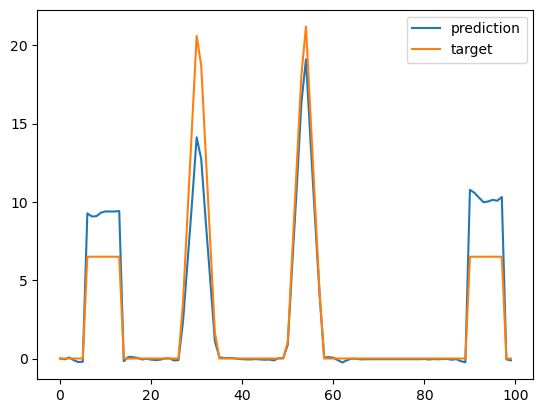

In [88]:
test_idx = 30

#plt.plot(test_input[test_idx,0].numpy()*std+mu, label='input')
plt.plot(test_output_conv1d[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target[test_idx,0].numpy(), label='target')
plt.legend()

## 3. Modèle avec couche d'attention

**À faire** : modifier le modèle défini plus haut en remplaçant la couche de convolution centrale par une couche d'attention.  
Rappel de la formule pour le mécanisme d'attention standard $$Y = \text{softmax} \left( QK^{T} \right) V $$  
On a les dimensions suivantes : $$ Q \in \mathcal{R}^{T\times D}, K \in \mathcal{R}^{T'\times D}, V \in \mathcal{R}^{T'\times D'} $$
où T (T') est la taille des séquences en entrée (sortie) de la couche d'attention, et D (D') est le nombre de *queries*/*keys* (*values*). Le nombre de *queries* et de *keys* doit correspondre, car les *queries* interrogent *keys*.  
D' correspond aussi au nombre de canaux en sortie.

In [58]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.conv_Q = nn.Conv1d(in_dim, out_dim, kernel_size=1, bias=False)
        self.conv_K = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_V = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        
    def forward(self, x, return_attention=False):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        
        A = torch.matmul(Q.transpose(1,2), K).softmax(2)
        y = torch.matmul(A, V.transpose(1,2)).transpose(1,2)
        if return_attention:
            return y, A
        else:
            return y

    
class Net_attention(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.conv_in = nn.Conv1d(in_channels, 64, kernel_size=5, padding=2)
        self.conv1 = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        self.conv_out = nn.Conv1d(64, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.att = SelfAttentionLayer(64, 64, 64)
        
    def forward(self, x, return_attention=False):
        x = self.relu( self.conv_in(x) )
        x = self.relu( self.conv1(x) )
        if return_attention:
            x, A = self.att(x, return_attention=True)
        else:
            x = self.att(x)
        x = self.relu( self.conv2(x) )
        x = self.conv_out(x)
        if return_attention:
            return x, A
        else:
            return x
    
model_attention = Net_attention()

### Entrainement

In [59]:
optimizer = optim.Adam(model_attention.parameters(), lr=learning_rate)

losses, val_losses = train_loop(model_attention, optimizer, loss_function, train_dataloader, test_dataloader, N_epochs)

Epoque 0 loss 5.010576248168945
Epoque 1 loss 3.451768398284912
Epoque 2 loss 2.6383612155914307
Epoque 3 loss 3.182143449783325
Epoque 4 loss 2.1969287395477295
Epoque 5 loss 2.0557565689086914
Epoque 6 loss 1.846994161605835
Epoque 7 loss 1.6147593259811401
Epoque 8 loss 1.1862767934799194
Epoque 9 loss 1.4260084629058838
Epoque 10 loss 1.192580223083496
Epoque 11 loss 1.2234748601913452
Epoque 12 loss 1.0126562118530273
Epoque 13 loss 1.3172038793563843
Epoque 14 loss 1.84108304977417
Epoque 15 loss 1.0492579936981201
Epoque 16 loss 0.9750655293464661
Epoque 17 loss 1.006516456604004
Epoque 18 loss 0.8865105509757996
Epoque 19 loss 1.2042326927185059
Epoque 20 loss 0.7303905487060547
Epoque 21 loss 0.6650087833404541
Epoque 22 loss 0.6210474371910095
Epoque 23 loss 0.5242941379547119
Epoque 24 loss 0.5883361101150513
Epoque 25 loss 0.5332306027412415
Epoque 26 loss 0.39174821972846985
Epoque 27 loss 0.5338870286941528
Epoque 28 loss 0.4395669400691986
Epoque 29 loss 0.46316885948181

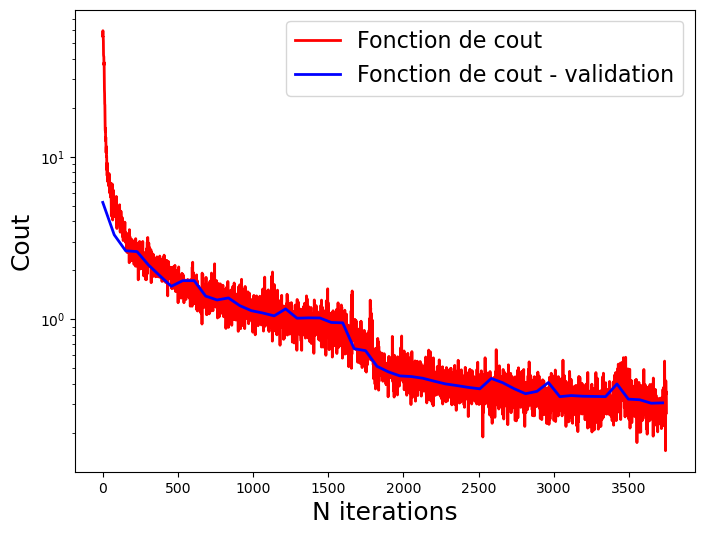

In [60]:
draw_loss(losses, val_losses, n_test_loops)

### Test

In [89]:
test_output_att = model_attention(test_input)

In [90]:
loss_function(test_output_att, test_target)

tensor(0.3062, grad_fn=<MseLossBackward0>)

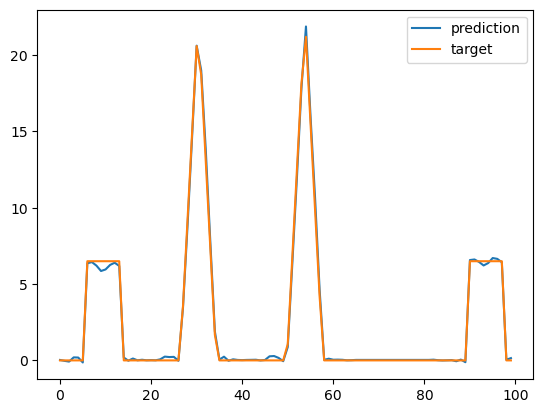

In [91]:
#plt.plot(test_input[10,0].numpy()*std+mu, label='input')
plt.plot(test_output_att[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target[test_idx,0].numpy(), label='target')
plt.legend()

### Visualisation de l'attention
On souhaite représenter la matrice d'attention (taille 100x100) pour une séquence de test.  
**À faire** : Modifier les classes `Net_attention` et `SelfAttentionLayer` afin qu'elles puissent retourner la matrice d'attention $$A = \text{softmax} \left( QK^{T} \right) $$ 

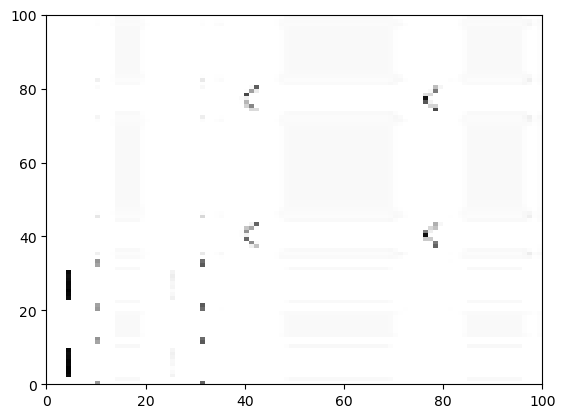

In [64]:
output, attention = model_attention(test_input[[test_idx]], return_attention=True)
plt.pcolor(attention.squeeze().detach().numpy(), cmap='gray_r')

## 4.Introduction au *positional encoding*
La couche d'attention définie au-dessus ne prend condidère aucunement la position des formes. On va introduire un nouvel objectif qui va dépendre de la position des formes afin d'illuster ici l'intérêt, et la nécessité, d'utiliser un *positional encoding* pour certaines tâches.

### Nouvelle tâche
Le nouvel objectif du réseau est de faire en sorte que les deux formes de gauche et les deux formes de droite aient la même hauteur, respectivement.

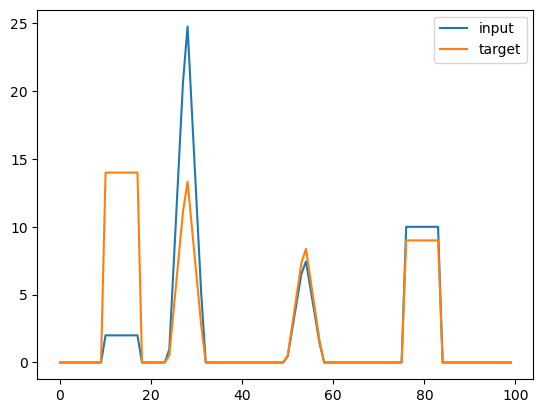

In [65]:
plt.plot(sequences_input[3,0], label='input')
plt.plot(sequences_target_position[3,0], label='target')
plt.legend()

On crée des nouveaux datasets et dataloaders avec les sequences cibles correspondant à la nouvelle tâche.

In [66]:
train_input_pos, test_input_pos, train_target_pos, test_target_pos = train_test_split(sequences_input,
                                                                      sequences_target_position,
                                                                      test_size=0.25)

# Normalisation des données
mu, std = train_input_pos.mean(), train_input_pos.std()
train_input_pos = (train_input_pos-mu)/std
test_input_pos = (test_input_pos-mu)/std

# Conversion des tableaux numpy vers des tenseurs reconnus par pytorch :
train_input_pos = torch.from_numpy(train_input_pos).type(torch.FloatTensor)
train_target_pos = torch.from_numpy(train_target_pos).type(torch.FloatTensor)
train_data_pos = TensorDataset(train_input_pos, train_target_pos)

test_input_pos = torch.from_numpy(test_input_pos).type(torch.FloatTensor)
test_target_pos = torch.from_numpy(test_target_pos).type(torch.FloatTensor)
test_data_pos = TensorDataset(test_input_pos, test_target_pos)

train_dataloader_pos = DataLoader(dataset=train_data_pos, batch_size=batch_size, shuffle=True)
test_dataloader_pos = DataLoader(dataset=test_data_pos, batch_size=batch_size, shuffle=False)

### Entrainement sans *positional encoding*

In [67]:
model_attention_noposition = Net_attention()

optimizer = optim.Adam(model_attention_noposition.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_attention_noposition, optimizer, loss_function, train_dataloader_pos, test_dataloader_pos, N_epochs)

Epoque 0 loss 6.293417930603027
Epoque 1 loss 3.435795307159424
Epoque 2 loss 3.0994813442230225
Epoque 3 loss 2.765516519546509
Epoque 4 loss 2.412818670272827
Epoque 5 loss 2.3348658084869385
Epoque 6 loss 2.685441017150879
Epoque 7 loss 3.1355531215667725
Epoque 8 loss 2.8869173526763916
Epoque 9 loss 1.9629781246185303
Epoque 10 loss 2.3147313594818115
Epoque 11 loss 2.6246230602264404
Epoque 12 loss 1.9821158647537231
Epoque 13 loss 1.790511965751648
Epoque 14 loss 2.026966094970703
Epoque 15 loss 2.0416457653045654
Epoque 16 loss 2.002427816390991
Epoque 17 loss 2.34580397605896
Epoque 18 loss 2.342698335647583
Epoque 19 loss 2.07039737701416
Epoque 20 loss 2.4539401531219482
Epoque 21 loss 1.9416182041168213
Epoque 22 loss 2.749526262283325
Epoque 23 loss 1.6700224876403809
Epoque 24 loss 2.211132764816284
Epoque 25 loss 1.9917316436767578
Epoque 26 loss 2.019155502319336
Epoque 27 loss 2.1055550575256348
Epoque 28 loss 2.06707501411438
Epoque 29 loss 2.287142038345337
Epoque 30

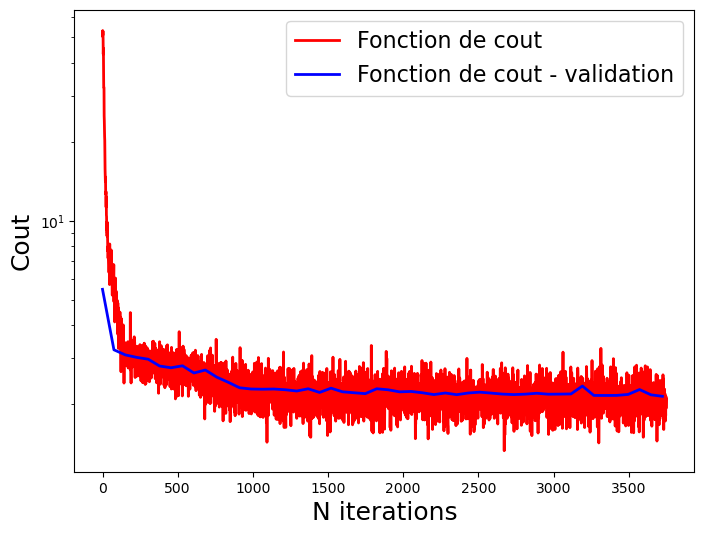

In [68]:
draw_loss(losses, val_losses, n_test_loops)

In [92]:
test_output_att_nopos = model_attention_noposition(test_input_pos)

In [93]:
loss_function(test_output_att_nopos, test_target_pos)

tensor(2.1452, grad_fn=<MseLossBackward0>)

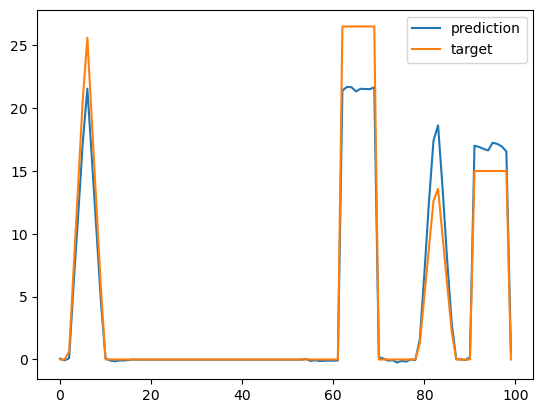

In [108]:
test_idx = 15

#plt.plot(test_input_pos[test_idx,0].numpy()*std+mu, label='input')
plt.plot(test_output_att_nopos[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target_pos[test_idx,0].numpy(), label='target')
plt.legend()

### Entrainement avec *positional encoding*
On va encoder en binaire la position de chaque point des séquences, puis concaténer cet encodage avec nos inputs.

In [72]:
def binary_positional_encoder(len_seq):
    c = np.ceil(np.log(len_seq) / np.log(2.0))
    o = 2**torch.arange(c).unsqueeze(1)
    pe = (torch.arange(len_seq).unsqueeze(0).div(o, rounding_mode = 'floor')) % 2
    return pe

**À faire** : créer le *positional encoding* correspondant aux séquences dans notre jeu de données.

In [73]:
pos_encoding = binary_positional_encoder(train_input_pos.shape[-1])

**À faire** : modifier les données d'entrainement et de test en concaténant chaque séquence d'input avec le *positional encoding* (même encodage pour toutes les séquences).  
Au final, pour un échantillon, on veux 8 canaux : 1 pour la séquence à proprement parler, et 7 additionels contenant le *positional encoding*.  
Au niveau des dimensions , on cherche à voir un tenseur de taille (N, 8, 100) suite à la concaténation, plutôt que (N, 1, 100) avant.

In [74]:
train_input_pe = torch.cat((train_input_pos, pos_encoding.expand(train_input_pos.shape[0],-1,-1)), dim=1)
test_input_pe = torch.cat((test_input_pos, pos_encoding.expand(test_input_pos.shape[0],-1,-1)), dim=1)

In [75]:
train_input_pe.shape

torch.Size([3750, 8, 100])

In [76]:
train_data_pos = TensorDataset(train_input_pe, train_target_pos)

test_data_pos = TensorDataset(test_input_pe, test_target_pos)

train_dataloader_pos = DataLoader(dataset=train_data_pos, batch_size=batch_size, shuffle=True)
test_dataloader_pos = DataLoader(dataset=test_data_pos, batch_size=batch_size, shuffle=False)

In [77]:
model_attention_pe = Net_attention(in_channels=8)
optimizer = optim.Adam(model_attention_pe.parameters(), lr=learning_rate)
losses, val_losses = train_loop(model_attention_pe, optimizer, loss_function, train_dataloader_pos, test_dataloader_pos, N_epochs)

Epoque 0 loss 7.166841506958008
Epoque 1 loss 5.321323871612549
Epoque 2 loss 3.7139413356781006
Epoque 3 loss 3.2948570251464844
Epoque 4 loss 2.7149198055267334
Epoque 5 loss 3.080005407333374
Epoque 6 loss 3.1717135906219482
Epoque 7 loss 2.7087488174438477
Epoque 8 loss 2.859093427658081
Epoque 9 loss 3.0631508827209473
Epoque 10 loss 3.1364150047302246
Epoque 11 loss 2.683246612548828
Epoque 12 loss 2.320505142211914
Epoque 13 loss 1.9391593933105469
Epoque 14 loss 1.5639179944992065
Epoque 15 loss 1.4450111389160156
Epoque 16 loss 1.6617921590805054
Epoque 17 loss 1.986037254333496
Epoque 18 loss 1.574034333229065
Epoque 19 loss 1.2490836381912231
Epoque 20 loss 1.5378265380859375
Epoque 21 loss 1.422391414642334
Epoque 22 loss 1.1199724674224854
Epoque 23 loss 1.485559105873108
Epoque 24 loss 0.9601163268089294
Epoque 25 loss 0.8206782341003418
Epoque 26 loss 1.4208638668060303
Epoque 27 loss 1.2177690267562866
Epoque 28 loss 1.4206808805465698
Epoque 29 loss 1.6443763971328735


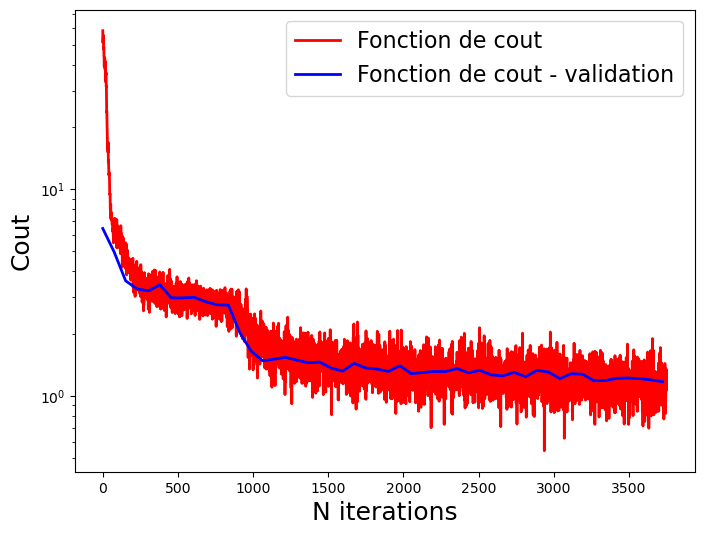

In [78]:
draw_loss(losses, val_losses, n_test_loops)

In [105]:
test_output_att_pos = model_attention_pe(test_input_pe)

In [106]:
loss_function(test_output_att_pos, test_target_pos)

tensor(1.1689, grad_fn=<MseLossBackward0>)

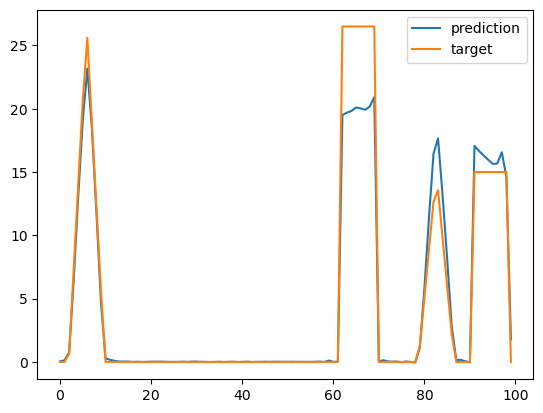

In [109]:
#plt.plot(test_input[10,0].numpy()*std+mu, label='input')
plt.plot(test_output_att_pos[test_idx,0].detach().numpy(), label='prediction')
plt.plot(test_target_pos[test_idx,0].numpy(), label='target')
plt.legend()